In [50]:
### Code written by Hector J. Hortua for the paper Bayesian deep learning for cosmic volumes with modified gravity arXiv:2309.00612 


from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)]) # Notice here
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)




from tqdm import tqdm
import sys
#cloned from https://github.com/janosh/tf-mnf
from tf_mnf import models 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pathlib import Path,PurePath
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import zipfile
import glob
from tensorflow.keras.layers import Input,Conv3D, BatchNormalization,Dropout,LeakyReLU,Flatten,Dense,GlobalAveragePooling3D,MaxPooling3D,AveragePooling3D,GlobalMaxPool3D
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential

# !pip install classification-models-3D
from classification_models_3D.tfkeras import Classifiers
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors
tfk = tf.keras
RANDOM=123
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [52]:
data = pd.read_csv('latin_hypercube_params.txt', sep="\s", header=0)

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [53]:
data.head()

,index,Om,h,sigma8,fR0_scaled,fR0_sim
0,0,0.319057,0.621471,0.659495,0.567758,0.000002
1,1,0.225592,0.812328,0.717481,0.536195,0.000004
2,2,0.377067,0.533253,0.686238,0.418775,0.000065
3,3,0.167260,0.727625,0.884341,0.531757,0.000005
4,4,0.225614,0.810414,0.621485,0.437325,0.000042


In [54]:
data.describe()

,index,Om,h,sigma8,fR0_scaled,fR0_sim
count,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1249.50000,0.304534,0.698586,0.802698,0.498826,0.000022
std,721.83216,0.115499,0.116635,0.115332,0.058121,0.000026
min,0.00000,0.100086,0.500186,0.600012,0.400071,0.000001
25%,624.75000,0.204806,0.594697,0.702775,0.448074,0.000003
50%,1249.50000,0.310886,0.696834,0.804256,0.498063,0.000010
75%,1874.25000,0.402320,0.798831,0.899479,0.549520,0.000033
max,2499.00000,0.499873,0.899938,0.999838,0.599851,0.000100


In [55]:
array= np.arange(0,2500,1)
array
data['filename'] = array.tolist()

In [56]:
data.columns

Index(['index', 'Om', 'h', 'sigma8', 'fR0_scaled', 'fR0_sim', 'filename'], dtype='object')

In [58]:
image_File_64=''
def omega_bh2(x):    
    return x["omega_b"] * x["h"]* x["h"] 
def omega_mh2(x):    
    return x["omega_m"] * x["h"]* x["h"]
def S8(x):    
    return x["sigma_8"] * (x["omega_m"]/0.3)**0.5

In [59]:
data['filename_path']=data.apply(
         lambda row: 'density_field_latin_hypercube/'+str(int(row.filename))+'/df_m_128_z=0.npy',axis=1)

In [60]:
data['filename_path']

0       jorge/jorge/density_field_latin_hypercube/0/df...
1       jorge/jorge/density_field_latin_hypercube/1/df...
2       jorge/jorge/density_field_latin_hypercube/2/df...
3       jorge/jorge/density_field_latin_hypercube/3/df...
4       jorge/jorge/density_field_latin_hypercube/4/df...
                              ...                        
2495    jorge/jorge/density_field_latin_hypercube/2495...
2496    jorge/jorge/density_field_latin_hypercube/2496...
2497    jorge/jorge/density_field_latin_hypercube/2497...
2498    jorge/jorge/density_field_latin_hypercube/2498...
2499    jorge/jorge/density_field_latin_hypercube/2499...
Name: filename_path, Length: 2500, dtype: object

In [61]:
filename_64=data['filename_path']
filename_names=['filename_path']
params=['Om', 'h', 'sigma8', 'fR0_scaled']
len_params=len(params)

In [13]:
removes=[]
def min_values(df,image_File):
     try:
         image=np.load(image_File+df,allow_pickle=True)
         min_val=image.min()
         return min_val
     except:
         print("Error! Could not load encoder for feature ", Path(df).parts[0])
         removes.append(int(Path(df).parts[0]))
         return None
def max_values(df,image_File):
     try:
         image=np.load(image_File+df,allow_pickle=True)
         max_val=image.max()
         return max_val
     #import pdb;pdb.set_trace()
     except:
         print("Error! Could not load encoder for feature ", Path(df).parts[0])
         return None

In [14]:
shuffle_data= data.sample(frac=1,random_state=RANDOM).reset_index(drop=True)
label_df=shuffle_data
Train_LSS_data, Test_LSS = train_test_split(label_df, test_size=0.2,random_state=RANDOM)
Train_LSS, Validation_LSS = train_test_split(Train_LSS_data, test_size=0.1,random_state=RANDOM)
Data_train_length =Train_LSS.shape[0]

In [15]:
shuffle_data

,index,Om,h,sigma8,fR0_scaled,fR0_sim,filename,filename_path
0,2386,0.326215,0.703919,0.811267,0.417343,0.000067,2386,jorge/jorge/density_field_latin_hypercube/2386...
1,1298,0.349374,0.659167,0.605903,0.462941,0.000023,1298,jorge/jorge/density_field_latin_hypercube/1298...
2,1995,0.398515,0.591944,0.637442,0.412037,0.000076,1995,jorge/jorge/density_field_latin_hypercube/1995...
3,2097,0.478454,0.638831,0.908263,0.546926,0.000003,2097,jorge/jorge/density_field_latin_hypercube/2097...
4,289,0.171622,0.773584,0.959046,0.439274,0.000040,289,jorge/jorge/density_field_latin_hypercube/289/...
...,...,...,...,...,...,...,...,...
2495,1147,0.360253,0.810617,0.959075,0.471844,0.000019,1147,jorge/jorge/density_field_latin_hypercube/1147...
2496,2154,0.276906,0.641261,0.930226,0.450494,0.000031,2154,jorge/jorge/density_field_latin_hypercube/2154...
2497,1766,0.155160,0.746843,0.700996,0.582037,0.000002,1766,jorge/jorge/density_field_latin_hypercube/1766...
2498,1122,0.157192,0.856196,0.947440,0.425997,0.000055,1122,jorge/jorge/density_field_latin_hypercube/1122...


In [16]:
features= Train_LSS[params].values
num_feratures=len(params)
scaler = MinMaxScaler()
scaler.fit(features)
print(scaler.data_max_)
print(scaler.data_min_)

[0.49977939 0.89993787 0.99983828 0.59985074]
[0.10018186 0.50018637 0.60001234 0.40007124]


In [17]:
removes=[]
min_val_64 = Train_LSS.filename_path.map(lambda x: min_values(x, image_File=image_File_64)).min()
max_val_64 = Train_LSS.filename_path.map(lambda x: max_values(x, image_File= image_File_64)).max()
data = data.drop(labels=removes, axis=0)

In [18]:
def normalization_data_32(array):
    thres=1.
    return 2*np.log(array-min_val_32+thres)/np.log(max_val_32-min_val_32+thres)-1./2#array
def normalization_data_64(array):
    thres=1.
    return 2*np.log(array-min_val_64+thres)/np.log(max_val_64-min_val_64+thres)-1./4.#array
    #return (array-min_val_64)/(max_val_64-min_val_64)#array

def normalization_features(feat):
    return (feat-scaler.data_min_)/(scaler.data_max_-scaler.data_min_)

def normalization_features_mean(feat):
  return feat*(scaler.data_max_-scaler.data_min_)+scaler.data_min_
def normalization_features_var(feat):
  return feat*(scaler.data_max_-scaler.data_min_)**2


def load_arrays(path,dim='32'):
  
  if dim=='32':
    image_ = np.load(image_File_32+path.numpy().decode())
    image =normalization_data_32(image_)
  else:
    image_ = np.load(image_File_64+path.numpy().decode())
    image =normalization_data_64(image_)
  #import pdb;pdb.set_trace()
  return image.reshape(image_.shape+(1,))

def tf_data_array(filenames1, features):
  [feat,]= tf.py_function(normalization_features, [features], [tf.float64])
  [image_64,] = tf.py_function(func= load_arrays,  inp=[filenames1,'64'], Tout=[tf.float64])
  image_64.set_shape(ma_64.shape+(1,))
  feat.set_shape(features.shape)
  return image_64,  feat

(array([2.7059e+04, 7.9010e+03, 7.9220e+03, 8.0300e+03, 8.3630e+03,
        8.7070e+03, 9.0350e+03, 9.3820e+03, 9.9360e+03, 1.0193e+04,
        1.0693e+04, 1.1144e+04, 1.1474e+04, 1.1836e+04, 1.2169e+04,
        1.2654e+04, 1.3162e+04, 1.3567e+04, 1.3654e+04, 1.4140e+04,
        1.4577e+04, 1.4921e+04, 1.5072e+04, 1.5454e+04, 1.5729e+04,
        1.6060e+04, 1.6361e+04, 1.6726e+04, 1.6789e+04, 1.7568e+04,
        1.7556e+04, 1.7424e+04, 1.8138e+04, 1.8033e+04, 1.8291e+04,
        1.8540e+04, 1.8824e+04, 1.8974e+04, 1.8941e+04, 1.9052e+04,
        1.9224e+04, 1.9429e+04, 1.9485e+04, 1.9729e+04, 1.9640e+04,
        1.9477e+04, 1.9743e+04, 1.9781e+04, 1.9897e+04, 1.9678e+04,
        1.9722e+04, 1.9940e+04, 1.9667e+04, 1.9691e+04, 1.9976e+04,
        1.9806e+04, 1.9707e+04, 1.9583e+04, 1.9405e+04, 1.9353e+04,
        1.9105e+04, 1.8970e+04, 1.8891e+04, 1.8746e+04, 1.8287e+04,
        1.8568e+04, 1.8193e+04, 1.8106e+04, 1.7788e+04, 1.7498e+04,
        1.7544e+04, 1.7072e+04, 1.6997e+04, 1.68

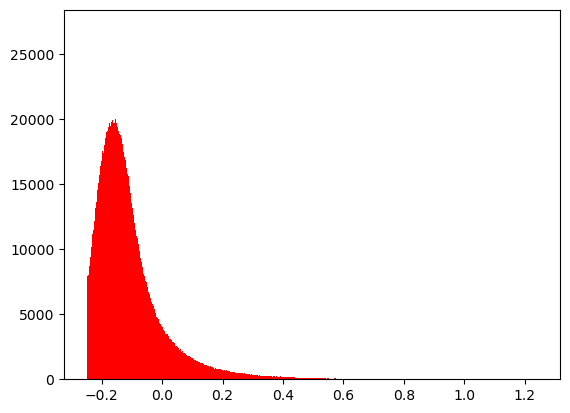

In [19]:
ma_64=np.load(image_File_64+filename_64[1])
plt.hist(normalization_data_64(ma_64.flatten()), bins='auto',color='red')

In [20]:
ma_64.shape

(128, 128, 128)

In [21]:
BATCH_SIZE=8
def datasets_iteration(dataset_row,files_mod, training=True):
    filename_64=dataset_row[files_mod[0]]
    features=dataset_row[params].values
    dataset = tf.data.Dataset.from_tensor_slices((filename_64,features))
    print(dataset)
    if training:
        dataset =dataset.shuffle(len(dataset_row),seed=RANDOM)
    dataset = dataset.map(tf_data_array).batch(BATCH_SIZE)
    return dataset

In [22]:
Train_dataset= datasets_iteration(Train_LSS,filename_names)
Validation_dataset= datasets_iteration(Validation_LSS,filename_names)
Test_dataset= datasets_iteration(Test_LSS,filename_names,False)
for i,j in Train_dataset.take(1):
    print(i.shape,j.shape)
Train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>
<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>
<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>
(8, 128, 128, 128, 1) (8, 4)


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 128, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>

In [23]:
beta = tf.Variable(1.0)
beta._trainable = False
def warmup(epoch):
    value = (epoch/10.0) * (epoch <= 10.0) + 1.0 * (epoch > 10.0)
    #print("beta:", value)
    #tf.keras.backend.set_value(beta, value)
from tensorflow.keras.callbacks import LambdaCallback
wu_cb = LambdaCallback(on_epoch_end=lambda epoch, log: warmup(epoch))

In [24]:
import datetime
logdir = "tf-mnf/tfboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

In [25]:
#del[mnf_lenet]
mnf_lenet = models.MNFLeNet3DResnet(model_name='resnet18',n_classes=len_params,pooling='avg')

def loss_fn(labels, preds):
    cross_entropy = -preds.log_prob(labels)
    entropic_loss = tf.reduce_mean(cross_entropy)
    kl_loss = mnf_lenet.kl_div() / Data_train_length
    loss = entropic_loss + beta * kl_loss
    tf.summary.scalar("negative log-likelihood", entropic_loss,step=Data_train_length//BATCH_SIZE)
    tf.summary.scalar("KL divergence_times_beta",  beta* kl_loss,step=Data_train_length//BATCH_SIZE)
    tf.summary.scalar("KL divergence",  kl_loss,step=Data_train_length//BATCH_SIZE)
    tf.summary.scalar("KL divergence",  beta,step=Data_train_length//BATCH_SIZE)
    tf.summary.scalar("loss", loss,step=Data_train_length//BATCH_SIZE)

    return loss

In [26]:
epochs=50*5
adam = tf.optimizers.Adam(3e-3)

In [ ]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min' ,factor=0.8,verbose=1,
                              patience=5, min_lr=1e-7)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,mode='min',restore_best_weights=True,
)
checkpoint_filepath = 'tf-mnf/logs/checkpointnew'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mse',
    mode='min',
    save_best_only=True)


mnf_lenet.compile(loss=loss_fn, optimizer=adam, metrics=["mse"])
#mnf_lenet.load_weights('tf-mnf/logs/checkpointsenet')

mnf_hist = mnf_lenet.fit(
     Train_dataset, epochs=epochs,
           validation_data=Validation_dataset,  callbacks=[reduce_lr,callback,wu_cb,model_checkpoint_callback],verbose=1)

Epoch 1/250


2023-08-04 02:34:23.332124: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:370] Cancel Transpose nodes around Pad: transpose_before=mnf_le_net3d_resnet/batch_normalization/FusedBatchNormV3-0-1-TransposeNCDHWToNDHWC-LayoutOptimizer pad=mnf_le_net3d_resnet/zero_padding3d_18/Pad transpose_after=mnf_le_net3d_resnet/mnf_conv3d/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/mnf_le_net3d_resnet/mnf_conv3d/Conv3DBackpropFilterV2-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/mnf_le_net3d_resnet/mnf_conv3d/Shape-0-TransposeNDHWCToNCDHW-LayoutOptimizer,mnf_le_net3d_resnet/mnf_conv3d/Square_1-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/mnf_le_net3d_resnet/mnf_conv3d/Mul_1-1-TransposeNDHWCToNCDHW-LayoutOptimizer
2023-08-04 02:34:44.506723: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB (rounded to 134217728)requested by op SameWorkerRecvDone
If the cause is memory fragment

In [ ]:
mnf_lenet.summary()

In [ ]:
mnf_lenet.layers[19].count_params()

In [85]:
mnf_lenet.kl_div()

<tf.Tensor: shape=(), dtype=float32, numpy=758542.2>

In [29]:
mnf_lenet.evaluate(Test_dataset)

2023-08-03 05:41:29.483488: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:370] Cancel Transpose nodes around Pad: transpose_before=mnf_le_net3d_resnet/batch_normalization/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=mnf_le_net3d_resnet/zero_padding3d_18/Pad transpose_after=mnf_le_net3d_resnet/mnf_conv3d/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer,mnf_le_net3d_resnet/mnf_conv3d/Square_1-0-TransposeNDHWCToNCDHW-LayoutOptimizer,mnf_le_net3d_resnet/mnf_conv3d/Shape-0-TransposeNDHWCToNCDHW-LayoutOptimizer
2023-08-03 05:41:34.811147: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


 1/63 [..............................] - ETA: 22:36 - loss: 4631.7993 - mse: 0.7342

2023-08-03 05:41:35.889528: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x564d0bddfce0


63/63 [==============================] - 134s 2s/step - loss: 4632.1084 - mse: 0.7949


[4632.1083984375, 0.7948899865150452]

In [64]:
predictions=mnf_lenet.predict(Test_dataset)

2023-08-03 05:49:27.687017: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:370] Cancel Transpose nodes around Pad: transpose_before=mnf_le_net3d_resnet_2/batch_normalization_54/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=mnf_le_net3d_resnet_2/zero_padding3d_38/Pad transpose_after=mnf_le_net3d_resnet_2/mnf_conv3d_58/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer,mnf_le_net3d_resnet_2/mnf_conv3d_58/Square_1-0-TransposeNDHWCToNCDHW-LayoutOptimizer,mnf_le_net3d_resnet_2/mnf_conv3d_58/Shape-0-TransposeNDHWCToNCDHW-LayoutOptimizer
2023-08-03 05:49:29.610117: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


63/63 [==============================] - 32s 398ms/step


In [32]:
predictions.shape

(500, 4)

In [33]:
x_image_total=[]
y_total=[]
for x, y in Test_dataset:
    x_image= mnf_lenet.predict(x)
    x_image_total.append(x_image)
    y_total.append(y)
#print(x.shape,y.shape)

1/1 [==============================] - 2s 2s/step


In [35]:
prediction=np.concatenate(x_image_total,axis=0)
ytrue=np.concatenate(y_total,axis=0)

In [34]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [38]:
r2_score(ytrue,prediction,multioutput='raw_values')

array([ 0.60435815, -0.76717453,  0.75837394, -0.91688678])

In [39]:
mean_squared_error(ytrue,prediction,multioutput='raw_values')

array([0.03429424, 0.14930875, 0.02046996, 0.1559954 ])

In [29]:
mnf_lenet.evaluate(Test_dataset)

2023-07-16 23:25:06.378826: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:370] Cancel Transpose nodes around Pad: transpose_before=mnf_le_net3d_resnet/batch_normalization/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=mnf_le_net3d_resnet/zero_padding3d_18/Pad transpose_after=mnf_le_net3d_resnet/mnf_conv3d/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer,mnf_le_net3d_resnet/mnf_conv3d/Square_1-0-TransposeNDHWCToNCDHW-LayoutOptimizer,mnf_le_net3d_resnet/mnf_conv3d/Shape-0-TransposeNDHWCToNCDHW-LayoutOptimizer
2023-07-16 23:25:11.413834: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


 1/63 [..............................] - ETA: 33:09 - loss: -99.4532 - mse: 0.1157

2023-07-16 23:25:12.877498: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55e47b7d2e50


63/63 [==============================] - 59s 438ms/step - loss: -99.2986 - mse: 0.0926


[-99.29862976074219, 0.09264963120222092]

In [26]:
mnf_lenet.evaluate(Test_dataset)

125/125 [==============================] - 142s 1s/step - loss: -3.3816 - mse: 0.0938


[-3.381575107574463, 0.09383955597877502]

In [27]:
mnf_lenet.save_weights('modelmnfresnet18a')

In [28]:
mnf_lenet.load_weights('modelmnfresnet18a')
mnf_lenet.evaluate(Test_dataset)

125/125 [==============================] - 32s 259ms/step - loss: -3.3424 - mse: 0.0902


[-3.342449426651001, 0.09015525877475739]

## Model implemented via  classification_models_3D

In [55]:
from classification_models_3D.tfkeras import Classifiers
from volumentations import *
ResNet18a, preprocess_input = Classifiers.get('resnet18')
modelflip = ResNet18a(input_shape=(64, 64, 64, 3),include_top=False, pooling = 'avg',weights=None)
def _untransformed_scale_constraint(t):
    return tf.clip_by_value(t, -1000,
                            tf.math.log(0.2))

kernel_posterior_fn = tfp.layers.default_mean_field_normal_fn(
      untransformed_scale_initializer=tf.compat.v1.initializers.random_normal(
          mean=-9.,
          stddev=0.1),
          untransformed_scale_constraint=_untransformed_scale_constraint)
divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / Data_train_length

inputs64 = Input(ma_64.shape+(1,))
x = tf.keras.layers.Lambda(tf.tile, arguments={'multiples':(1,1,1, 1, 3)})(inputs64)
x=modelflip(x)
x = tf.keras.layers.GlobalAveragePooling3D(name='pool1')(x)
x = tfp.layers.DenseFlipout(
 units=tfp.layers.MultivariateNormalTriL.params_size(len_params),
      kernel_posterior_fn=kernel_posterior_fn,kernel_divergence_fn = divergence_fn)(x)
outputbnn=tfp.layers.MultivariateNormalTriL(len_params,convert_to_tensor_fn=tfp.distributions.Distribution.mean)(x)
model3 = Model(inputs64, outputbnn, name="BNNs")
model3.summary()
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

epochs=50*3
adam = tf.optimizers.RMSprop()#,(1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min' ,factor=0.8,verbose=1,
                              patience=5, min_lr=1e-6)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,mode='min',restore_best_weights=True)


model3.compile(optimizer=adam, loss=negloglik ,metrics=['mse'])
model3.fit(
     Train_dataset, epochs=epochs,
           validation_data=Validation_dataset,  callbacks=[reduce_lr,callback],verbose=1)
# model3.load_weights('save_models_jorge4/modelmnfflipresnet18')
# model3.evaluate(Test_dataset)

Model: "BNNs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 64, 1)]   0         
                                                                 
 lambda_1 (Lambda)           (None, 64, 64, 64, 3)     0         
                                                                 
 model_1 (Functional)        (None, 2, 2, 2, 512)      33214281  
                                                                 
 pool1 (GlobalAveragePooling  (None, 512)              0         
 3D)                                                             
                                                                 
 dense_flipout (DenseFlipout  (None, 14)               14350     
 )                                                               
                                                                 
 multivariate_normal_tri_l_1  ((None, 4),              0      

/opt/conda/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)
/opt/conda/lib/python3.7/site-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=trainable)


Epoch 1/150


2023-05-03 01:56:41.639169: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:370] Cancel Transpose nodes around Pad: transpose_before=BNNs/model_1/bn_data/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=BNNs/model_1/zero_padding3d_18/Pad transpose_after=BNNs/model_1/conv0/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/BNNs/model_1/conv0/Conv3D/Conv3DBackpropFilterV2-0-TransposeNDHWCToNCDHW-LayoutOptimizer,gradient_tape/BNNs/model_1/conv0/Conv3D/Shape-0-TransposeNDHWCToNCDHW-LayoutOptimizer


186/186 [==============================] - ETA: 0s - loss: 52.8770 - mse: 0.4663

2023-05-03 01:57:21.682426: I tensorflow/core/grappler/optimizers/generic_layout_optimizer.cc:370] Cancel Transpose nodes around Pad: transpose_before=BNNs/model_1/bn_data/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer pad=BNNs/model_1/zero_padding3d_18/Pad transpose_after=BNNs/model_1/conv0/Conv3D-0-TransposeNDHWCToNCDHW-LayoutOptimizer


186/186 [==============================] - 45s 222ms/step - loss: 52.8770 - mse: 0.4663 - val_loss: 6080.1069 - val_mse: 2.0098 - lr: 0.0010
Epoch 2/150
 44/186 [======>.......................] - ETA: 30s - loss: 50.9256 - mse: 0.4054

KeyboardInterrupt: 

In [40]:
df1=pd.read_csv('seresnet.csv')

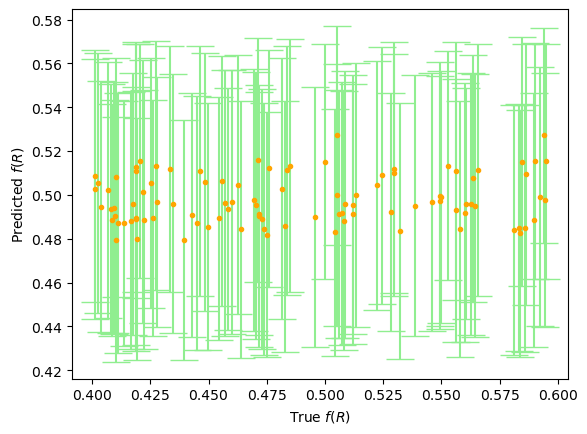

In [37]:
exple=1
df1a=df1.sample(100)
plt.errorbar(df1a['target_ep3'], df1a['prediction3'][:], yerr =np.sqrt(df1a['var3'][:]), ecolor = 'lightgreen',  capsize=10,fmt = '.', color = 'orange')
plt.xlabel(r"True $f(R)$")
plt.ylabel(r"Predicted $f(R)$")
#plt.savefig("fr.png")
plt.show()

In [44]:
df1a=df1.sample(200)
import matplotlib 
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
plt.rcParams.update({'font.size': 18})

In [52]:
groups1 = df1a.groupby(np.digitize(df1a.var1, bins1))

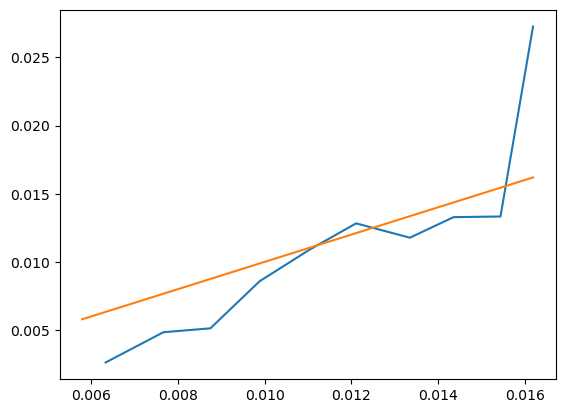

In [53]:
xt=np.linspace(df1a.var1.min(), df1a.var1.max(), 15)
plt.plot(groups1.mean().var1,groups1.mean().prediction1mse)
plt.plot(xt,xt)

In [120]:
%matplotlib inline
import getdist
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
for x, y_ in Test_dataset.take(5):
  y =normalization_features_mean(y_) 
  prediction_sample_mean=[]
  prediction_sample_std=[]
  valu_real=y
  samples_= mnf_lenet(x).sample(10000)
  samples_=normalization_features_mean(samples_) 
names = ["x%s"%i for i in range(4)]
labels =  ['\Omega_m','h','\sigma_8','f_{R0}']

Removed no burn in


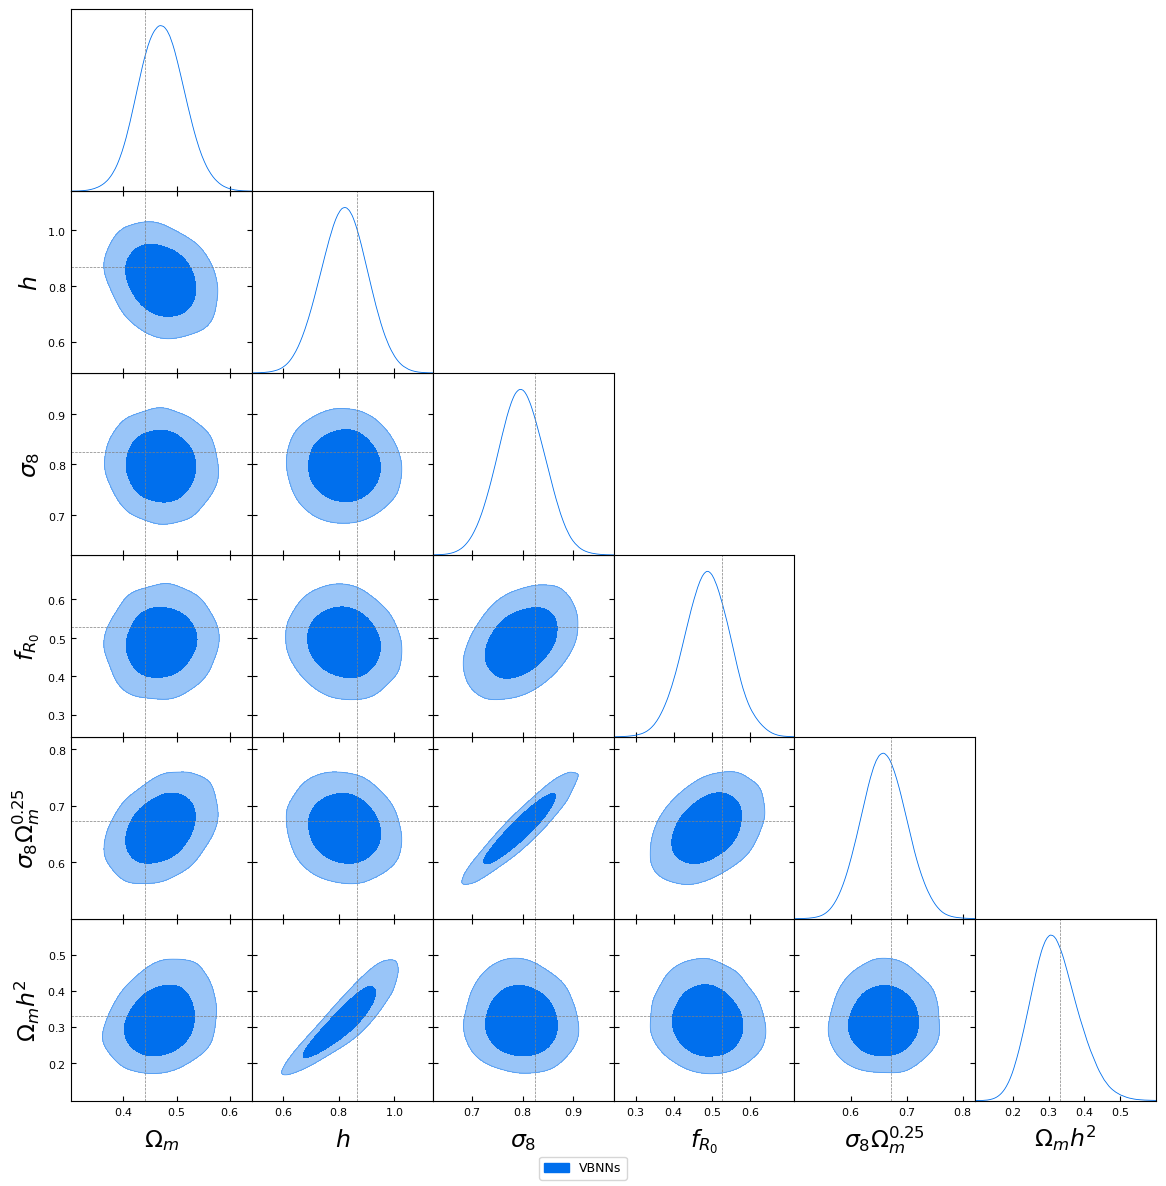

In [123]:
n_instance=2
#!pip install getdist
samples = MCSamples(samples=samples_.numpy()[:,n_instance,:],names = names, labels = labels)
y_0=y[n_instance][0].numpy()
y_1=y[n_instance][1].numpy()
y_2=y[n_instance][2].numpy()
y_3=y[n_instance][3].numpy()
p=samples.getParams()

samples.addDerived(p.x0**(0.25)*p.x2, name='x4', label='\sigma_8\Omega_m^{0.25}', range=[0,None])
samples.addDerived(p.x0*p.x1**2, name='x5', label='\Omega_m h^{2}', range=[0,None])

g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 18
g.settings.axes_labelsize =20
g.triangle_plot(samples, filled=True,
                #upper_roots = [samplesflip],
                #upper_kwargs = {'contour_colors':['green']},
                legend_labels=['VBNNs'],legend_loc='lower center',
                markers={'x0':y_0,'x1': y_1,'x2': y_2,'x3':y_3,'x4': y_0**(0.25)*y_2,'x5': y_0*y_1**2})
g.export('plotorge/triangular_plot_vbb.pdf')


In [122]:
print(samples.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$\Omega_m       $} & $0.471^{+0.087}_{-0.084}   $\\

{\boldmath$h              $} & $0.82^{+0.16}_{-0.17}      $\\

{\boldmath$\sigma_8       $} & $0.797^{+0.091}_{-0.092}   $\\

{\boldmath$f_{R_0}        $} & $0.49^{+0.12}_{-0.12}      $\\

$\sigma_8\Omega_m^{0.25}   $ & $0.659^{+0.082}_{-0.079}   $\\

$\Omega_m h^{2}            $ & $0.32^{+0.13}_{-0.12}      $\\
\hline
\end{tabular}
